# **Prob_theta**

##### Note that the file name is bad, but I dare not change it (overlaps in github etc.). I just keep this name

### This file contains the code for creating some density operator (matrix, Wigner) and derive representations from different angles. From these representations samples are gathered using rejection sampling.

### The purpose is to create pseudo-samples for the Likelyhood-function described in A.I. Lvovsky et. al.

### The likelyhood function (eq. 1, Lvovsky), including overlap functions (eq. 8, Lvovsky) is formulated with code. Our pseudo-samples are applied to the function with our density matrix (which we know by fact is correct)

### Another file will be created for using the function on different (unknown) density matrices to derive the maximum likelyhood (MaxLik)

##### First we import the necessary packages

In [1]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import quad
import math as mt
import random
import cmath as cm

In [2]:
# We initialize the density matrix of a coherent state (which we want to analyze)

# N is the number of Fock states in our Hilbert space

N = 20

# eig_val is the eigenvalue for our coherent state

eig_val = np.sqrt(2)

rho_coherent_dm = qt.coherent_dm(N, eig_val)

rho_coherent = qt.coherent(N, np.sqrt(2))

In [3]:
type = rho_coherent_dm.dtype

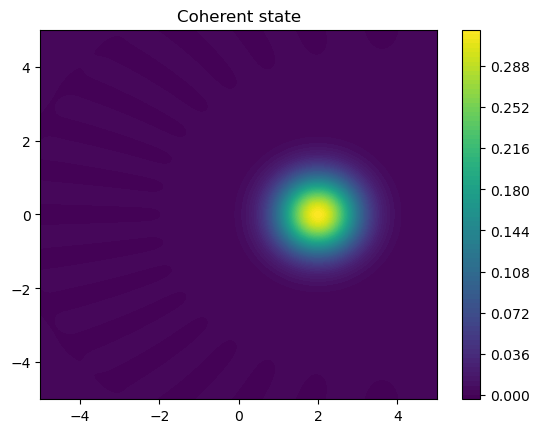

In [4]:
# Below we create the Wigner function using qtip and choose an x-space from -lnspc to with 200 points

lnspc = 5

xvec = np.linspace(-lnspc,lnspc,200)

W_coherent = qt.wigner(rho_coherent_dm, xvec, xvec)

cont0 = plt.contourf(xvec, xvec, W_coherent, 100)
lbl0 = plt.title("Coherent state")
cbar = plt.colorbar(cont0)

plt.show()

##### We define the Wigner function. Below the coherent state is shifted by 45 degrees

In [5]:
# Simple rotation function

def rot(theta):
    return (1j*theta*qt.num(N)).expm()

# 1j is just i and rho_coherent is a vector (can be rotated as such)


#### As an example we consider the coherent state rotated by 45 degrees (pi/4)

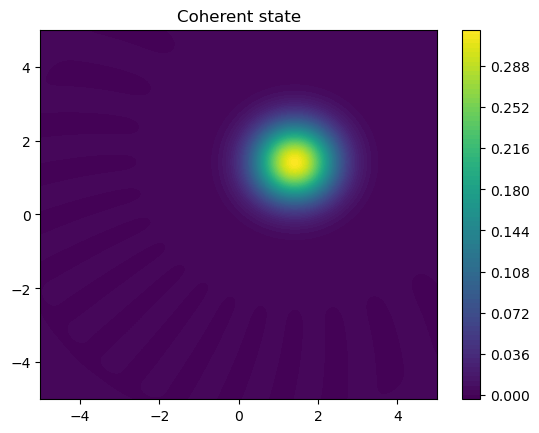

In [6]:
W_coherent = qt.wigner(rot(mt.pi/4)*rho_coherent, xvec, xvec)

cont0 = plt.contourf(xvec, xvec, W_coherent, 100)
lbl0 = plt.title("Coherent state")
cbar = plt.colorbar(cont0)

plt.show()

##### We can do this process for different values of theta, here theta=[0,30,60,90,120,150,180]

In [7]:
num_thetas = [0,30,60,90,120,150,180]
thetas = [i*mt.pi/180 for i in num_thetas]

N_thetas = len(thetas)

W_coherents = [0]*N_thetas

# xs contains all the x values for different values of theta

xs = np.zeros((N_thetas,len(W_coherent[0])))

# The for loop below updates the xs array to contain the x-values (int over all p) at different angles

for i in range(N_thetas):
    W_coherents[i] = qt.wigner(rot(thetas[i])*rho_coherent, xvec, xvec)
    cohe = W_coherents[i]
    seq = np.array([np.sum(cohe[:,j]) * (xvec[1]-xvec[0])/20 for j in range(len(W_coherents[0][0]))])
    xs[i] = seq

##### Below, the values of p(x_theta) are shown for the different values of theta

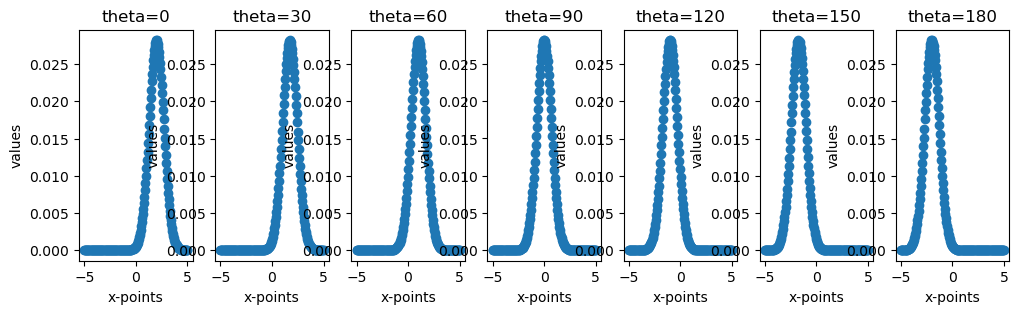

In [8]:
fig, axes = plt.subplots(1, 7, figsize=(12,3))

scat0 = axes[0].scatter(xvec, xs[0])
scat1 = axes[1].scatter(xvec, xs[1])
scat2 = axes[2].scatter(xvec, xs[2])
scat3 = axes[3].scatter(xvec, xs[3])
scat4 = axes[4].scatter(xvec, xs[4])
scat5 = axes[5].scatter(xvec, xs[5])
scat6 = axes[6].scatter(xvec, xs[6])

i = 0

for ax in axes.flat:
    ax.set(xlabel='x-points', ylabel='values', title='theta=' + str(num_thetas[i]))
    i+=1

plt.show()

##### Now that we have different probability distributions for x we can use the rejection sampling technique

In [9]:
# Rejection sample function of an array of points

def Rsamp(arr, lnspcfnc):
    """
    Generates a rejection sample using a desired line spacing
    
    ------------------------------------------------------------

    arr : an array containing the given histogram values
    lnspcfnc : the x-axis grid size of span(-lnspcfnc;lnspcfnc)
    """
    maxval = max(arr)    
    Ry = np.random.uniform(0,maxval,200)
    xgrid = np.linspace(-lnspcfnc,lnspcfnc,200)
    indices = np.where(arr>Ry)
    Rsample = xgrid[indices]
    
    return Rsample

# For loop for iteration; maybe change (avoid for-loops)

def RepRsamp(iter,arr,lnspcfnc):
    """ 
    Generates a rejection sample of any number of iterations

    ----------------------------------------------------------
    
    iter : the number of iterations
    arr : an array containing the given histogram values
    lnspcfnc : the x-axis grid size of span(-lnspcfnc;lnspcfnc)
    """
    RsampIter = np.array([])
    for i in range(iter):
        RsampIter = np.append(RsampIter,Rsamp(arr,lnspcfnc))
    return RsampIter

In [10]:
vals = Rsamp(xs[0], 5)
valsIter = RepRsamp(2, xs[0],5)

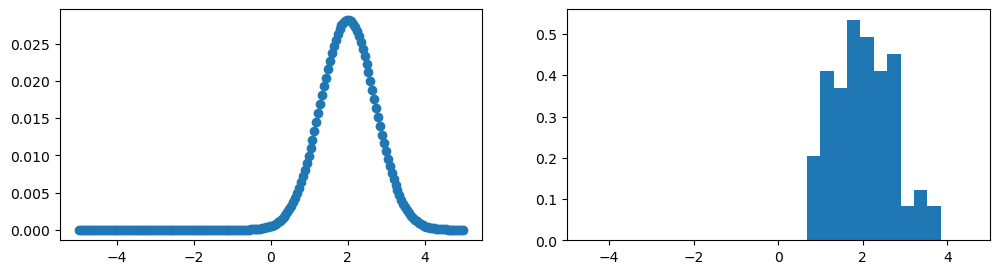

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(12,3))

scat0 = axes[0].scatter(xvec, xs[0])
hist1 = axes[1].hist(valsIter,bins=10, density=True, stacked=True)

plt.xlim(-lnspc,lnspc)
plt.show()

##### We use this method to have samples for all theta-values {0,30,60,90,120,150}

In [12]:
num_thetas = [0,30,60,90,120,150]
rad_thetas = [i*mt.pi/180 for i in num_thetas]

N_thetas = len(num_thetas)

samples_theta = [0] * N_thetas
lengths = []

iter = 2

# Since the length of the array depends on the sample we cannot make samples_theta into a numpy array
# Therefore we keep it as a list for now

for j in range(N_thetas):
    samples_theta[j] = RepRsamp(iter, xs[j], 4)


# Definition of Likelyhood-function

In [13]:
# Definition of the likelyHood-function

def likelyHood(pr,f):
    """
    Returns the value of the likelyhood-functions (eq. 1 of Lvovsky et. al.)
    
    -------------------------------------------------------------------------

    pr : array of prj values (probability values)
    f : array of fj values (number of occurences for each observation)
    """
    product = 1.
    for j in range(len(f)):
        product *= pr[j]**f[j]
#        print(product) #If debugging
    return product

# Overlap function defined as eq. 8 in the paper

def overlap(n,theta_indx,x):
    """
    Calculates the overlap of two states (see eq. 8 of Lvovsky et. al.)

    -------------------------------------------------------------------

    n : index of density operator
    x : observation value (or yj values)
    theta_index : index of theta values (e.g. in list [0,30,60,90,120,150])
    """
    thetas = [0,30,60,90,120,150]
    theta = thetas[theta_indx]
    hermit = sp.special.hermite(n)
    overl = np.real(cm.exp(1j * n * theta)) * (2./mt.pi)**(1/4) * hermit(mt.sqrt(2)*x) \
            /(mt.sqrt(2**n * mt.factorial(n)))*mt.exp(-x**2)
    return overl

# Creates (help)matrices to calculate the overlap

def CreateMatrixOverlap(rows,cols,theta_indx,yjs):
    """
    Creates a matrix with with elements given by the overlap function
    The function works as a help-function to derive values without making a nested for-loop
    
    -----------------------------------------------------------------
    rows : number of rows
    cols : number of columns
    theta_indx : index of theta values (e.g. in list [0,30,60,90,120,150])
    yjs : list of observations
    """
    # This function could and should be optimized, but for now it's functional and I understand it

    M = np.ones((rows,cols))

    # If we have more columns than rows it means that we initialize each row element as an overlap element

    if cols > rows:
        for i in range(rows):
            for j in range(cols):
                M[i,j] = overlap(j,theta_indx,yjs[i])

    # If we have more rows than columns it means that we initialize each column element as an overlap element

    else:
        for i in range(cols):
            for j in range(rows):
                M[j,i] = overlap(j,theta_indx,yjs[i])

    return M

##### With the Likelyhood function we take as input a state operator (in this first case we know the state operator) and compute value. This value is largest (closest to one) for the correct state operator.

##### We can choose a value for theta_indx depending on what theta we look at

In [14]:
# We define theta_indx to be a dynamic variable (choose the sample of theta=0,30,60,90,120,150 by index)

# I should make this a dictionary

theta_indx = 0

sample = np.histogram(samples_theta[theta_indx],bins=100)

In [15]:
# fjs is our number of occurences

yjs = sample[1]
yjs = np.array(yjs)

fjs = sample[0]
fjs = np.array(fjs) #These values do not sum to 1!?

# Below we convert the density operator from type Qobj to type numpy-array (if the density operator is of type Qobj)

if rho_coherent_dm.dtype == type:
    rho_coherent_dm = rho_coherent_dm.full()
    rho_coherent_dm = np.real(np.array(rho_coherent_dm))

# What we are doing here is that we are updating yjs to only include the midpoint value
# of each bin which matches the dimension of fvals (i.e. we have the same number of j's)

for i in range(len(yjs)):
    if i < len(yjs)-1:
        yjs[i] = yjs[i] + (yjs[i+1] - yjs[i])/2

yjs = np.delete(yjs,-1)

# Dimensions of density operator, rho below. In our case the dimension of rho is 20 x 20

M = rho_coherent_dm.shape[0]
N = rho_coherent_dm.shape[1]

# This is our prjs; we update this later

prjs = np.zeros(len(fjs))

##### Old derivation of overlaps (slow; takes app. 17s)

In [16]:
#K = len(prjs)

#for k in range(K):
#    sum = 0
#    for i in range(M):
#        for j in range(N):
#            seq = overlap(i,theta_indx,yjs[k]) * overlap(j,theta_indx,yjs[k]) * rho_coherent_dm[i,j]
#            sum += seq
#    prjs[k] = sum


##### Derivation using matrix multiplication (faster; takes app. 1.6s)

In [17]:
# Matrix multiplication to derive overlaps (much faster)

K = len(prjs)

Mnk = CreateMatrixOverlap(N,K,theta_indx,yjs)
#Mkn = CreateMatrixOverlap(K,N,theta_indx,yjs)
Mkn = np.conjugate(np.transpose(Mnk))

val = np.dot(rho_coherent_dm,Mnk)
val = np.dot(Mkn, val)

for k in range(K):
    prjs[k] = np.sum(val[k])

In [18]:
# The result does not seem correct

L = likelyHood(prjs,fjs)
print(L)


4.118172512798473
4.118172512798473
4.118172512798473
-13.121127223690882
-13.121127223690882
-13.121127223690882
-13.121127223690882
-13.121127223690882
-13.121127223690882
-13.121127223690882
-13.121127223690882
-13.121127223690882
-61.19013726249766
-61.19013726249766
-128.48085286602506
-128.48085286602506
251.28928426580947
-165.4532155159966
-165.4532155159966
-159.8568734076689
242.2756899062282
242.2756899062282
242.2756899062282
242.2756899062282
234.99643319436237
-353.4171831838572
-353.4171831838572
-353.4171831838572
-353.4171831838572
-905.8341987794508
-181.00899314772462
-181.00899314772462
-6.337151709796172
-15.13243912631095
-15.13243912631095
-32.88086438991694
-32.88086438991694
45.39525373114658
17.33871994725653
17.33871994725653
13.31655576339116
17.440740031227378
17.440740031227378
17.605587826314586
17.605587826314586
13.255845785326152
15.589965875930364
15.589965875930364
20.537536273066006
20.537536273066006
29.16590795411535
5.371099221098463
5.3710992210

## Ensemble that maximizes the likelyhood, L

In [36]:
def DivideElement(arr1,arr2):
    M = np.ones(len(arr1))

    for i in range(len(arr1)):
        M[i] = arr1[i]/arr2[i]
    
    return M

arrHelp = [1] * K

for i in range(len(Mnk[:,0])):
    arrHelp[i] = DivideElement(Mnk[i],prjs)

PiOp = np.dot(Mnk,Mkn)

print(PiOp)



[[ 6.36265268  6.11004337  5.37389077  4.26047807  2.9276304   1.55774979
   0.32726978 -0.62182595 -1.2032853  -1.39703199 -1.24730413 -0.84941433
  -0.32819621  0.18733762  0.58808964  0.80319371  0.80940858  0.63039069
   0.32673804 -0.02050445]
 [ 6.11004337  6.37524962  6.11744587  5.37430877  4.25382581  2.91554268
   1.54317962  0.31376648 -0.63098146 -1.20587743 -1.39244593 -1.2366707
  -0.83533028 -0.31408936  0.19804294  0.59280362  0.80078683  0.80048113
   0.61712198  0.31235342]
 [ 5.37389077  6.11744587  6.37538303  6.11027764  5.36158957  4.23866128
   2.90163473  1.5339226   0.31141909 -0.6258466  -1.19451253 -1.37762176
  -1.22200034 -0.82438824 -0.30954093  0.19509017  0.58306832  0.78663779
   0.78535988  0.6047052 ]
 [ 4.26047807  5.37430877  6.11027764  6.36236146  6.09456662  5.34701473
   4.22877837  2.89886238  1.53895116  0.32303969 -0.61045051 -1.17908176
  -1.36591217 -1.21686888 -0.82709668 -0.31944678  0.18038007  0.56711857
   0.77332008  0.77791324]
 [ 2.

In [21]:
def Rop(m,n):
    

SyntaxError: incomplete input (3651048394.py, line 2)